In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [13]:
import sys
sys.path.append('/content/drive/MyDrive')

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K

from dataset import DataGenerator
from SwinUNet import SwinUNet
from ConvUNet import ConvNeXTUNet

In [15]:
train_data = DataGenerator('/content/drive/MyDrive/data/train', batch_size = 64)
val_data = DataGenerator('/content/drive/MyDrive/data/val', batch_size = 64, predicting = True)

In [16]:
@tf.keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
  y_pred = tf.nn.softmax(y_pred)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.01)

@tf.keras.saving.register_keras_serializable()
def dice_coef_multilabel(y_true, y_pred, numLabels=35):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

In [17]:
swin_model = SwinUNet(128, 35, window_size = 4, patch_size=4, embed_dim = 96, depths = [2, 2, 6, 2], num_heads = [3, 6, 12, 24], attn_drop_rate = 0.2, proj_drop_rate = 0.2)
swin_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [18]:
swin_history = swin_model.fit(train_data, epochs = 25, validation_data = val_data)

Epoch 1/25
47/47 [==============================] - 411s 7s/step - loss: 0.5074 - accuracy: 0.4682 - dice_coef_multilabel: 0.2507 - val_loss: 0.5397 - val_accuracy: 0.5473 - val_dice_coef_multilabel: 0.2605
Epoch 2/25
47/47 [==============================] - 176s 4s/step - loss: 0.3308 - accuracy: 0.6760 - dice_coef_multilabel: 0.2936 - val_loss: 0.3639 - val_accuracy: 0.6792 - val_dice_coef_multilabel: 0.2799
Epoch 3/25
47/47 [==============================] - 162s 3s/step - loss: 0.3023 - accuracy: 0.7149 - dice_coef_multilabel: 0.3247 - val_loss: 0.3403 - val_accuracy: 0.7080 - val_dice_coef_multilabel: 0.3027
Epoch 4/25
47/47 [==============================] - 155s 3s/step - loss: 0.2902 - accuracy: 0.7319 - dice_coef_multilabel: 0.3455 - val_loss: 0.3102 - val_accuracy: 0.7106 - val_dice_coef_multilabel: 0.3225
Epoch 5/25
47/47 [==============================] - 159s 3s/step - loss: 0.2828 - accuracy: 0.7433 - dice_coef_multilabel: 0.3610 - val_loss: 0.2965 - val_accuracy: 0.7274 

In [19]:
os.makedirs('/content/drive/MyDrive/SaveModels/', exist_ok=True)
swin_model.save('/content/drive/MyDrive/SaveModels/swinmodel.keras', save_format="keras")

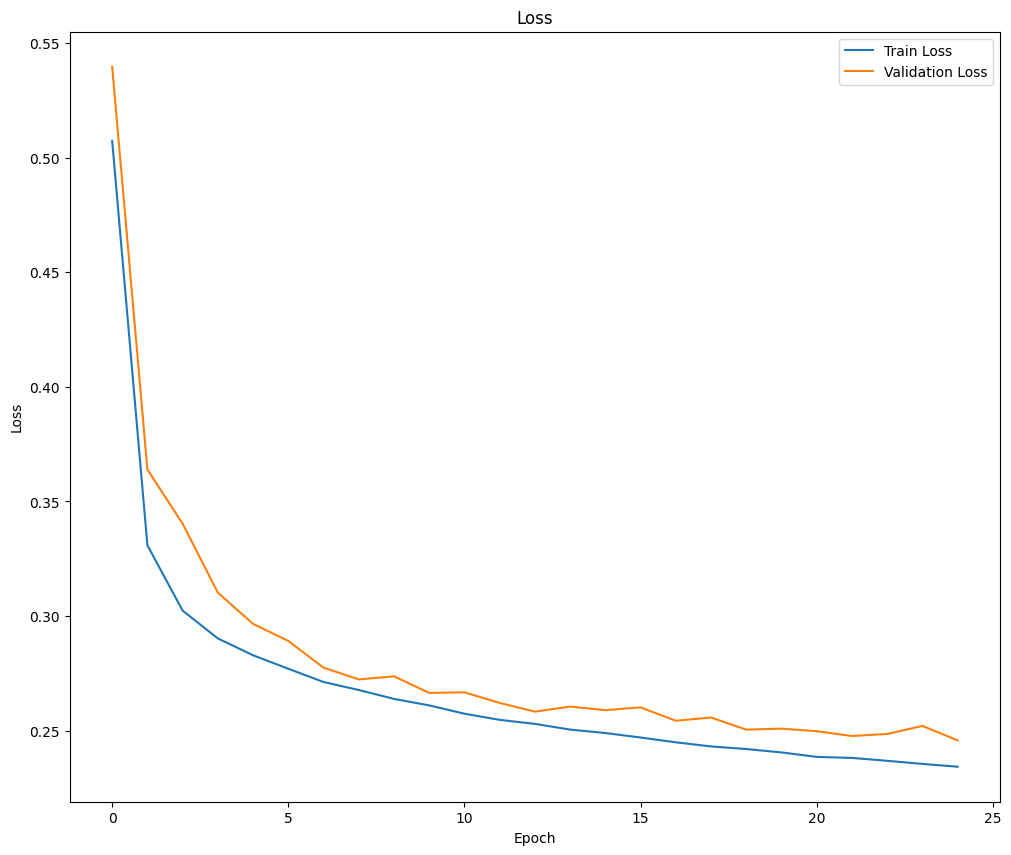

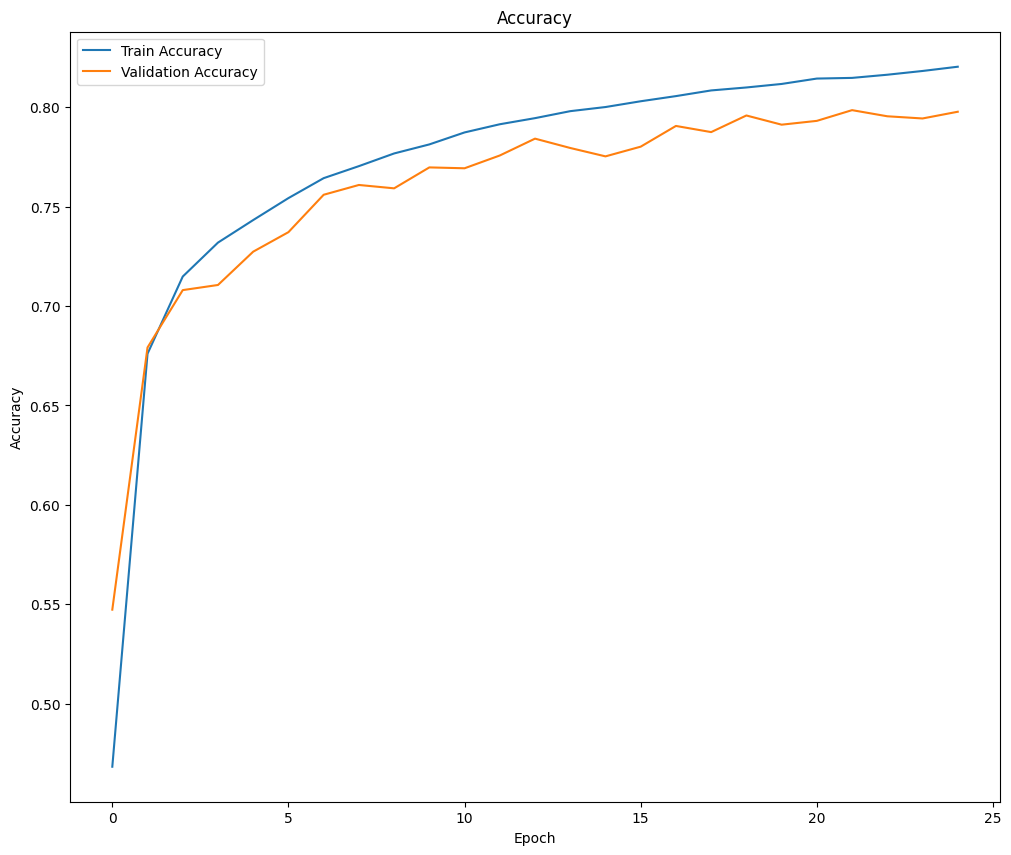

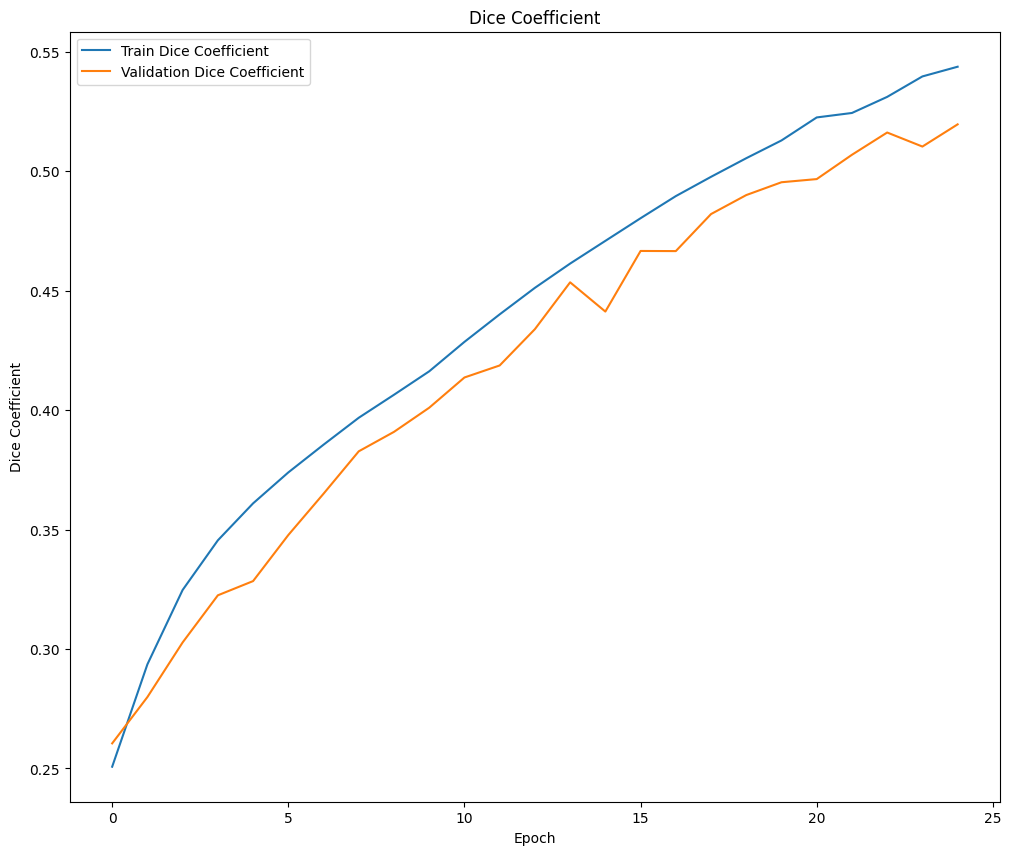

In [20]:
os.makedirs('/content/drive/MyDrive/save_plots/swinmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['loss'], label='Train Loss')
plt.plot(swin_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/swinmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['accuracy'], label='Train Accuracy')
plt.plot(swin_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/swinmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(swin_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/swinmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [21]:
conv_model = ConvNeXTUNet(128, 96, 35, [3, 3, 9, 3])
conv_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0005, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [22]:
conv_history = conv_model.fit(train_data, epochs = 25, validation_data = val_data)

Epoch 1/25
47/47 [==============================] - 217s 4s/step - loss: 0.5794 - accuracy: 0.3654 - dice_coef_multilabel: 0.2241 - val_loss: 0.7642 - val_accuracy: 0.3471 - val_dice_coef_multilabel: 0.2356
Epoch 2/25
47/47 [==============================] - 166s 4s/step - loss: 0.3523 - accuracy: 0.6432 - dice_coef_multilabel: 0.2563 - val_loss: 0.4501 - val_accuracy: 0.5178 - val_dice_coef_multilabel: 0.2420
Epoch 3/25
47/47 [==============================] - 171s 4s/step - loss: 0.3136 - accuracy: 0.7033 - dice_coef_multilabel: 0.3008 - val_loss: 0.4137 - val_accuracy: 0.5481 - val_dice_coef_multilabel: 0.2664
Epoch 4/25
47/47 [==============================] - 169s 4s/step - loss: 0.2952 - accuracy: 0.7282 - dice_coef_multilabel: 0.3314 - val_loss: 0.3308 - val_accuracy: 0.6810 - val_dice_coef_multilabel: 0.2965
Epoch 5/25
47/47 [==============================] - 167s 4s/step - loss: 0.2852 - accuracy: 0.7430 - dice_coef_multilabel: 0.3537 - val_loss: 0.3032 - val_accuracy: 0.7253 

In [23]:
conv_model.save('/content/drive/MyDrive/SaveModels/convnextmodel.keras', save_format="keras")

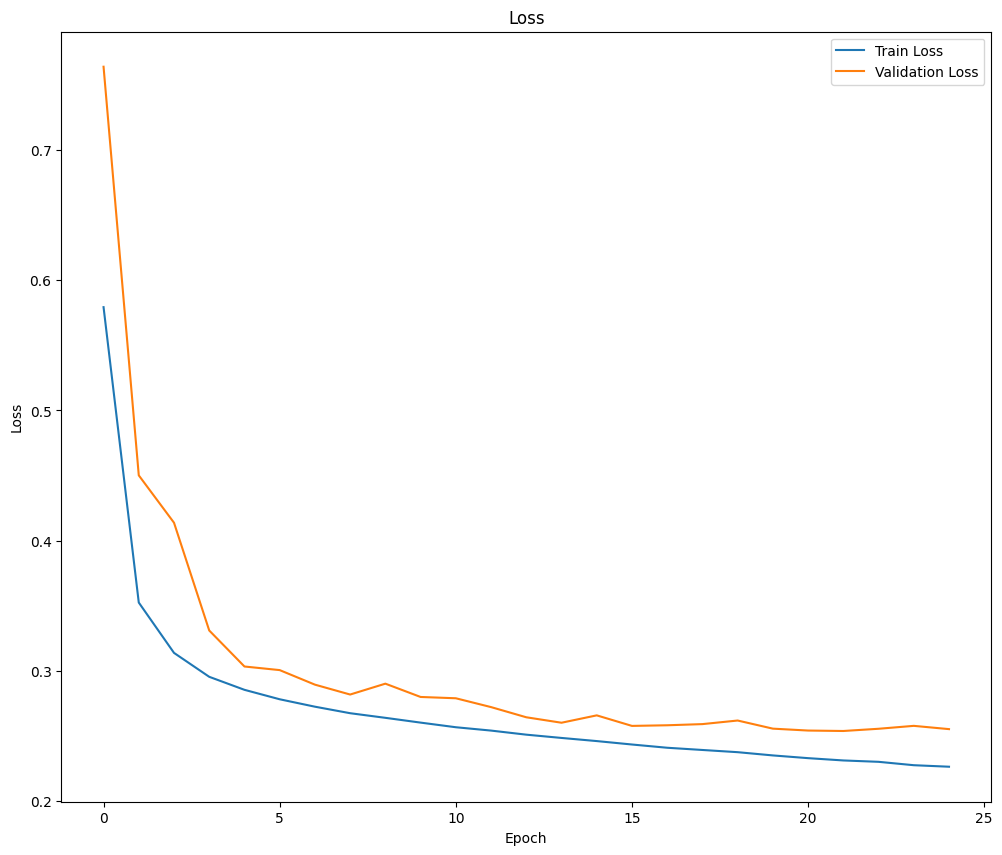

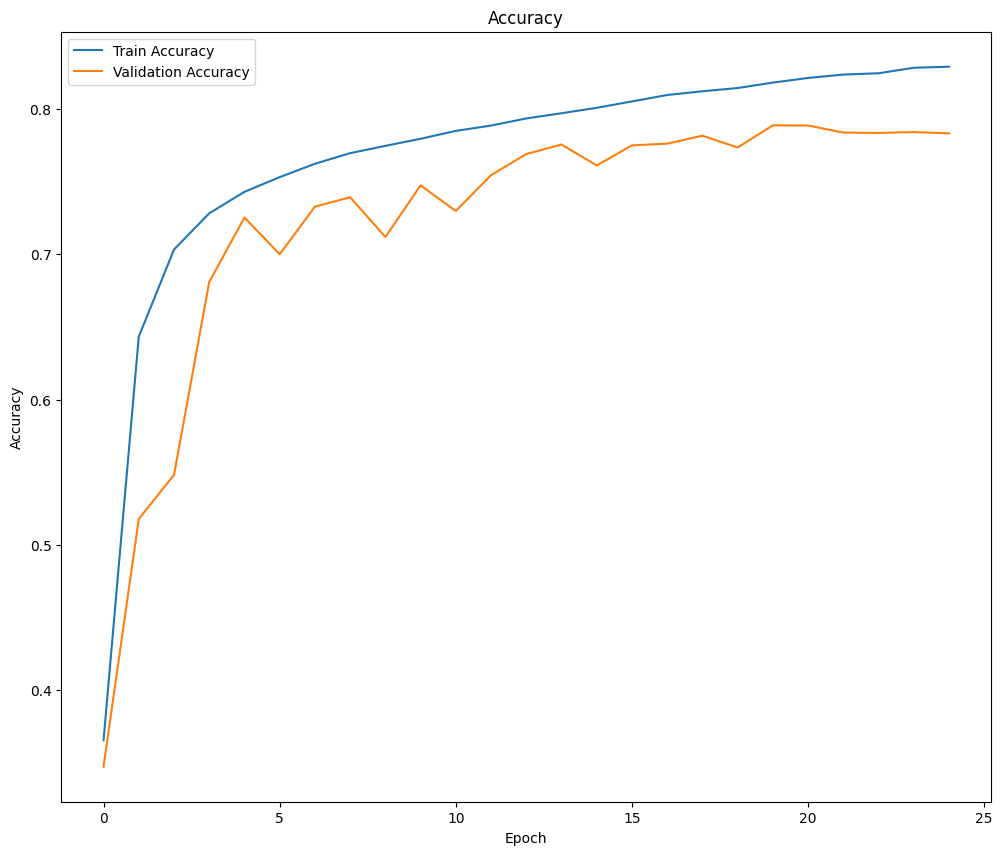

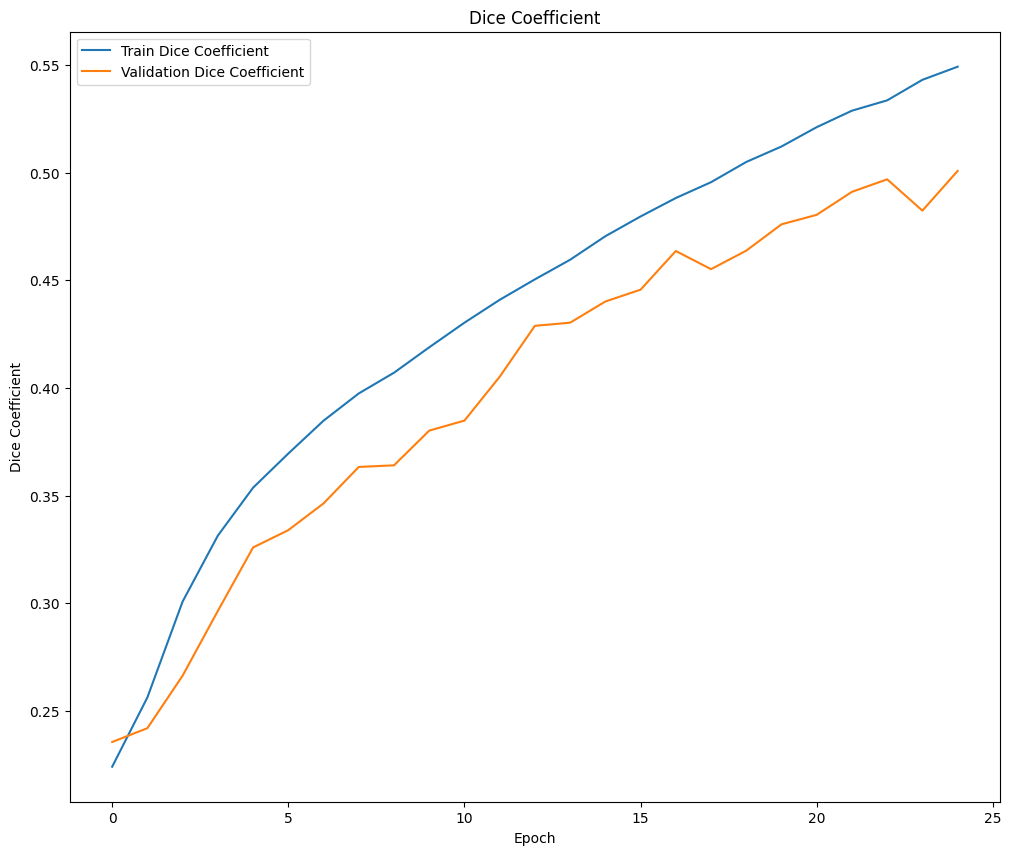

In [24]:
os.makedirs('/content/drive/MyDrive/save_plots/convmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['loss'], label='Train Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/convmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/convmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(conv_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/convmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [35]:
for img, mask in val_data:
  true_mask = mask[25:30]
  imgs = img[25:30]
  break

prediction = swin_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 0s 63ms/step


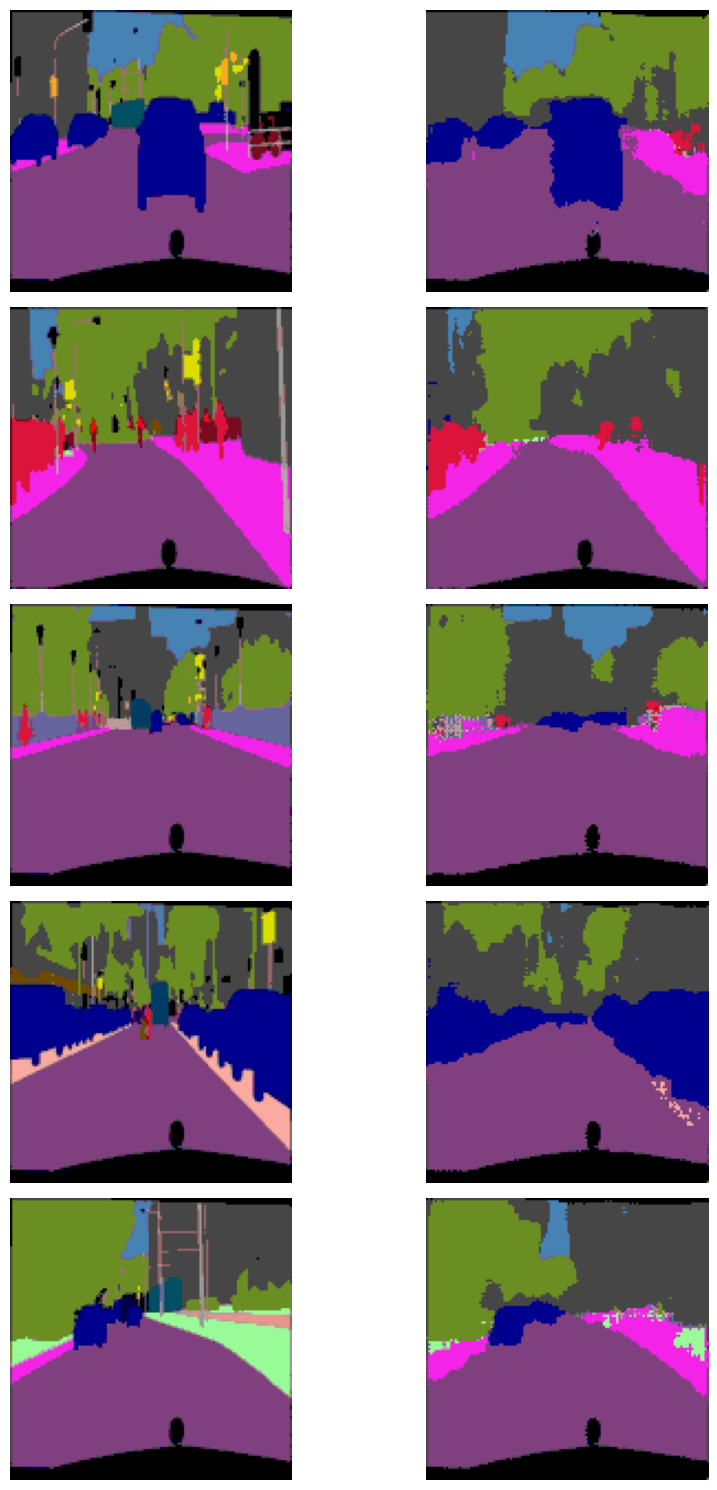

In [36]:
from labeldata import id_to_color
from PIL import Image

fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()



In [37]:
for img, mask in val_data:
  true_mask = mask[25:30]
  imgs = img[25:30]
  break

prediction = conv_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 0s 68ms/step


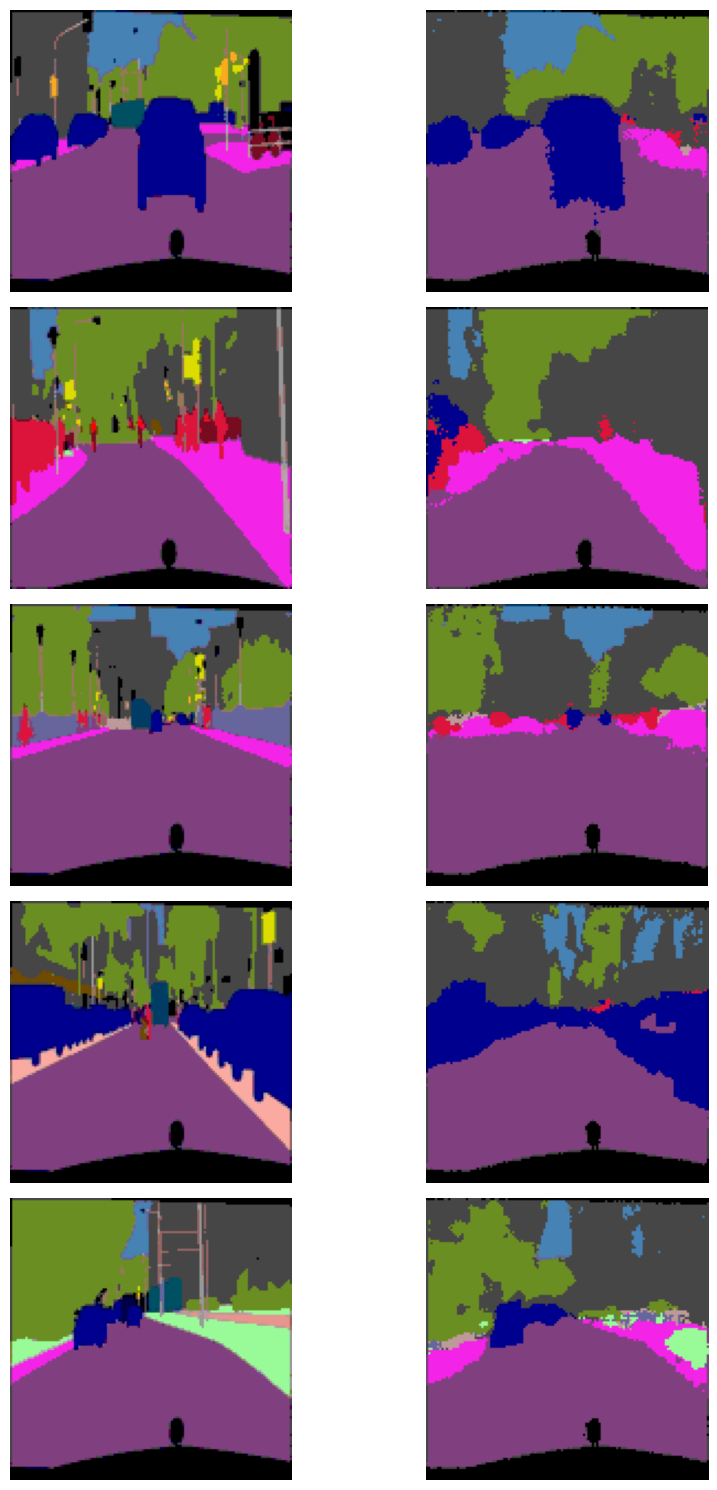

In [38]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()

